## Fine- Tuning LLM for Price Prediction
Given a product description, we want to predict its price.

In [3]:
# imports

import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset,Dataset,DatasetDict
# from items import Item
import matplotlib.pyplot as plt
from items import Item

c:\Users\abhid\Desktop\myprojects\fine-tuning-llm\.venv\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\abhid\.cache\huggingface\hub\models--meta-llama--Meta-Llama-3.1-8B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [4]:
%matplotlib inline

In [5]:
# loading environment keys
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [6]:
hf_token = os.environ['HF_TOKEN']
login(hf_token,add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
null_list = [None,'',[],{},'NA']

## Loading our Dataset from Amazon Reviews Huggingface

In [8]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances",split = 'full', trust_remote_code=True)

In [9]:
print('Nos of appliances: ',len(dataset))

Nos of appliances:  94327


### Viewing a sample datapoint

In [10]:
datapoint = dataset[-1]
datapoint

{'main_category': 'Tools & Home Improvement',
 'title': 'Edgewater Parts AP2039084-4 Rack Rollers Compatible With GE Dishwasher 4 Pack',
 'average_rating': 5.0,
 'rating_number': 2,
 'features': ['AP2039084-4 Rack Rollers Compatible With GE Dishwashers',
  '1 YEAR WARRANTY',
  'Replaces WD12X271, 2493, AH259136, DW113, DW604, EA259136, PS259136, WD12X0271, WD12X0426, WD12X0440, WD12X426, WD12X440',
  'Color White'],
 'description': ['AP2039084-4 Rack Rollers Compatible With GE Dishwasher Non-OEM replacement Replaces WD12X271, 2493, AH259136, DW113, DW604, EA259136, PS259136, WD12X0271, WD12X0426, WD12X0440, WD12X426, WD12X440 Color White'],
 'price': '9.95',
 'images': {'hi_res': ['https://m.media-amazon.com/images/I/51Pm1OHujBL._AC_SL1000_.jpg',
   'https://m.media-amazon.com/images/I/61zWDuzv9gL._AC_SL1001_.jpg'],
  'large': ['https://m.media-amazon.com/images/I/317qiLSbo4L._AC_.jpg',
   'https://m.media-amazon.com/images/I/41Av6g9rmcL._AC_.jpg'],
  'thumb': ['https://m.media-amazon.

## Observations
1) main category and title comes as text strings  
2) features come as list of text strings  
3) description also comes as list  
4) price comes as a string float or may come as float
5) details come as json encased in a string
6) Some appliances don't have price, so we have to exclude them.  
7) If they don't have title , we'll exclude those also


In [11]:
# How many have prices and titles
counter = 0
for d in dataset:
    try:
        price = float(d['price'])
        if price>0:
            counter+=1
    except:
        continue
    
print(100*counter/len(dataset))        

49.53618794194663


In [12]:
# How many doesn't have product title
counter = 0
for d in dataset:
    try:
        if d['title'] in null_list:
            counter+=1
            print(d)
            print('--'*30) 
    except:
        counter+=1
        print(d)  
        print('--'*30)      
print(counter)       

{'main_category': 'Tools & Home Improvement', 'title': '', 'average_rating': 3.6, 'rating_number': 8, 'features': [], 'description': [], 'price': 'None', 'images': {'hi_res': ['https://m.media-amazon.com/images/I/81P6cfqi4tL._AC_SL1500_.jpg', 'https://m.media-amazon.com/images/I/81G8yppnckL._AC_SL1500_.jpg', 'https://m.media-amazon.com/images/I/61GCtouPzrL._AC_SL1000_.jpg', 'https://m.media-amazon.com/images/I/61OrU4vS4rL._AC_SL1000_.jpg', 'https://m.media-amazon.com/images/I/61kCKbzIuUL._AC_SL1000_.jpg', 'https://m.media-amazon.com/images/I/61IljZl+2CL._AC_SL1000_.jpg', 'https://m.media-amazon.com/images/I/61GpbNtR5IL._AC_SL1000_.jpg'], 'large': ['https://m.media-amazon.com/images/I/41DXKVACdnL._AC_.jpg', 'https://m.media-amazon.com/images/I/41iLycS5ZAL._AC_.jpg', 'https://m.media-amazon.com/images/I/51DrYPCzItL._AC_.jpg', 'https://m.media-amazon.com/images/I/51ZNht6MD+L._AC_.jpg', 'https://m.media-amazon.com/images/I/51vUtny05oL._AC_.jpg', 'https://m.media-amazon.com/images/I/51OAlDQ

## Distribution of prices and character length of description

In [13]:
prices = []
lengths = []

for d in dataset:
    try:
        price = float(d['price'])
        title = d['title']
        if price>0 and title not in null_list:
            prices.append(price)
            contents = d['title'] + str(d['description']) + str(d['features']) + str(d['details'])
            lengths.append(len(contents))
    except:
        continue       
        

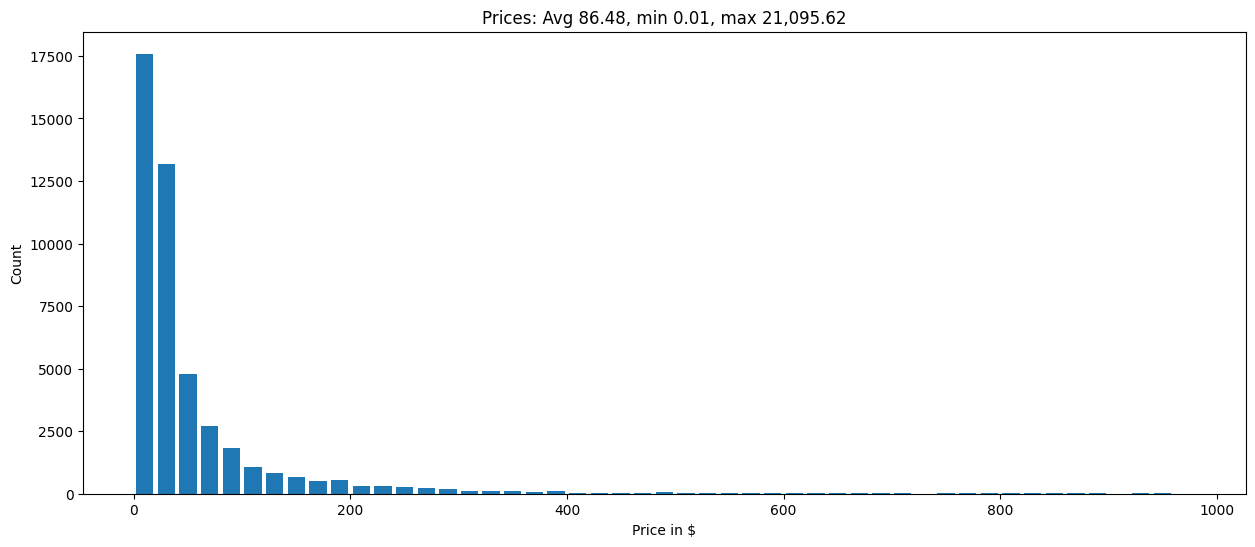

In [14]:
# Plot distribution of prices
plt.figure(figsize=(15,6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f}, min {min(prices):,.2f}, max {max(prices):,.2f}")
plt.xlabel('Price in $')
plt.ylabel('Count')
plt.hist(prices,rwidth = 0.8,bins=range(0,1000,20))
plt.show()

In [15]:
percentiles = [1,5,25,50,75,95,99]
percentile_values = np.percentile(prices,percentiles)
{f'{k}th percentile:': round(v,2) for (k,v) in zip(percentiles,percentile_values)}

{'1th percentile:': np.float64(5.77),
 '5th percentile:': np.float64(7.99),
 '25th percentile:': np.float64(14.99),
 '50th percentile:': np.float64(26.99),
 '75th percentile:': np.float64(58.13),
 '95th percentile:': np.float64(246.0),
 '99th percentile:': np.float64(1282.88)}

### Lets have a cutoff of prices till $1000, and take only those which have title

In [17]:
items = []
for d in dataset:
    try:
        price = float(d['price'])
        title = d['title']
        if price>0 and title not in null_list and price<=1000:
            item = Item(d,price)
            if item.include:
                items.append(item)            
    except:
        continue 
print(f"There are {len(items):,} items")    

There are 28,650 items


### Viewing sample objects from items

In [20]:
items[1]

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [22]:
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.


In [24]:
print(items[1].test_prompt())

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $


### Plot distribution of token counts

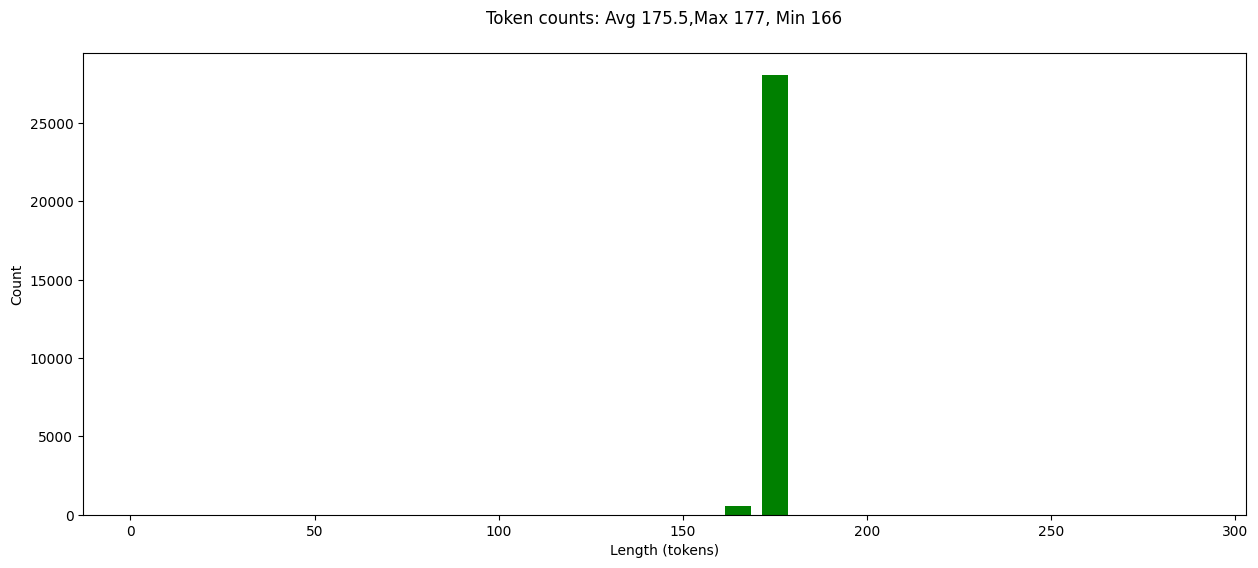

In [23]:
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f},Max {max(tokens)}, Min {min(tokens)}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

### Plot the distribution of prices

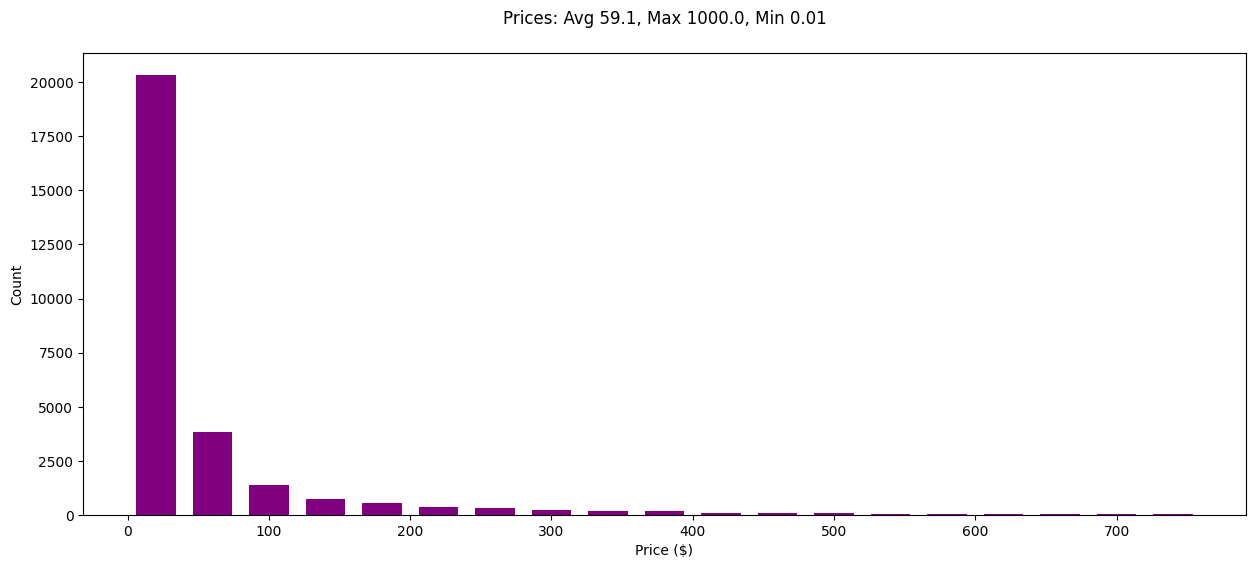

In [26]:
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f}, Max {max(prices)}, Min {min(prices)}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 800, 40))
plt.show()